Para evitar conflitos entre dependências e prejuízos ao seu sistema operacional, sugerimos executar este notebook e o servidor dentro de um ambiente virtual no conda.  

Baixe e instale o Anaconda installer para o seu sistema operacional:
    
[Linux](https://docs.conda.io/projects/conda/en/latest/user-guide/install/linux.html)
[Windows](https://docs.conda.io/projects/conda/en/latest/user-guide/install/windows.html)
[MacOS](https://docs.conda.io/projects/conda/en/latest/user-guide/install/macos.html)

Em seguida, crie um ambiente virtual chamado *sgbd* ( ou com qualquer outro nome que quiser ) rodando Python 3.7 ( diga sim à instalação dos pacotes ) :

```
conda create -n sgbd python=3.7 anaconda
```

Ative o ambiente:
    
```
source activate sgbd
```

Ao final de tudo, você pode destruir este ambiente, eliminando assim todos os pacotes que foram instalados. 

```
conda env remove -n sgbd
```

# Instalando dependências

Tome o cuidado de executar os comandos abaixo no terminal *(sgbd)*, que é ativado após o comando `source activate sgbd` ou alternativamente, `conda activate sgbd`.

```
pip install uncurl requests loguru Flask
pip install -U spacy
python -m spacy download en
```


# Obtendo os dados 

O dataset utilizado consiste nas primeiras frases de todos os artigos da Wikipedia em inglês.
Seu peso descompactado é de 934MB.

Há duas maneiras de baixá-lo:

Fazendo login no Kaggle e baixando direto da fonte: 

https://www.kaggle.com/mikeortman/wikipedia-sentences/ 

Ou então baixando diretamente de nosso mirror em um bucket na Amazon S3:

https://infufg.s3.amazonaws.com/wikipedia-sentences.zip

O arquivo `wikisent2.txt` deve ser extraído para a mesma pasta onde está este notebook.


# Iniciando o container

Abra um novo terminal para inicializar o Docker container. 

A depender da sua instalação do Docker, os comandos relacionados ao Docker talvez tenham que ser executados em modo administrador ( *sudo* ).

Carregue o Elasticsearch em um Docker container, conforme indica a documentação ( https://www.elastic.co/guide/en/elasticsearch/reference/current/docker.html ):

```
docker pull docker.elastic.co/elasticsearch/elasticsearch:7.1.1

docker run -p 9200:9200 -p 9300:9300 -e "discovery.type=single-node" docker.elastic.co/elasticsearch/elasticsearch:7.1.1
```

# Ingerindo os dados

Execute o arquivo `ingest.py` para transferir o dataset `wikisent2.txt` ao node do Elasticsearch rodando no Docker container. 

O comando abaixo deve ser executado no terminal do ambiente virtual ( no nosso caso, chamado *(sgbd)* ).

```
python ingest.py
```

Você não precisa deixar esse script executar até o final para prosseguir para as etapas seguintes.
Caso ele seja interrompido, a demonstração funcionará normalmente, só que com menos dados.
O script lhe informará o progresso atual, mas não é necessário que você espere até ele atingir 100%.

Caso você interrompa o script, poderá voltar a executá-lo novamente, sem perder o progresso alcançado.  
Os dados presentes na sua instância do Elasticsearch só serão destruídos após o fechamento do Docker container. 

# Fim!

Após executar as etapas acima, a nossa configuração inicial já está pronta. Todo o restante deste notebook é meramente demonstrativo.

Lembre-se que o nosso Docker container é efêmero. Isso significa que todos os dados que foram ingeridos pelo Elasticsearch serão apagados do seu sistema assim que o Docker container for desligado.

Você pode pular para o final desse tutorial e inicializar o servidor que executa a construção dos grafos de entidades nomeadas, ou então pode executar as células interativas abaixo que explicam passo a passo aquilo que o servidor está fazendo.

# Demonstração passo-a-passo

Execute as duas células abaixo ( clicando na célula e depois em Run ) para importar as bibliotecas e definir as funções necessárias para a demonstração passo-a-passo.

In [1]:
import pandas as pd
import random

import uncurl

import json
import requests
import sys
from time import sleep

import spacy

A função **pretty** enquadra respostas do Elasticsearch em dataframes do Pandas.  

A função **build_array** converte listas de consultas em um formato apropriado para requisições ao Elasticsearch.

In [2]:
def pretty(res):
    result = res.json()['hits']['hits']
    for item in result:
        item['text'] = item['_source']['text']
        del(item['_source'])
    return pd.DataFrame(result)
    
def build_array(array, field):
    output = []
    for item in array:
        output.append({
            "match" : {field: item}
        })
    return output

# Demonstração: Explorando o Elasticsearch

Aqui iremos explorar algumas das diversas funcionalidades do Elasticsearch. Este código não é executado pelo servidor Flask mencionado ao final da demonstração.

A biblioteca *uncurl* é útil para ajudar a converter comandos cURL da documentação do Elasticsearch em um formato apropriado para a biblioteca *requests*.

In [3]:
print(uncurl.parse("""curl -XPUT localhost:9200/_cluster/settings -d '{
    "transient" : {
        "cluster.routing.allocation.disk.threshold_enabled" : false
    }
}'"""))

requests.put("localhost:9200/_cluster/settings",
    data='{
    "transient" : {
        "cluster.routing.allocation.disk.threshold_enabled" : false
    }
}',
    headers={},
    cookies={},
)


Aqui demonstramos como o Elasticsearch aceita consultas simples escritas em seu dialeto de SQL. 
Na consulta abaixo, procuramos por linhas com as palavras *Mona Lisa*.

In [4]:
query = "SELECT * FROM wiki WHERE text LIKE '%Mona Lisa%'"
sql = { "query" : query }

response = requests.post("http://localhost:9200/_sql?format=txt",
    data= json.dumps(sql),
    headers={ "Content-Type": "application/json" },
    cookies={},
)

pd.set_option('display.max_colwidth', -1)
pd.DataFrame(response.text.split('\n')[2:-1]).head()

,0
0,"1000 Mona Lisas were a punk band from Hollywood, CA."
1,"11-20-79 is the debut studio album from American R&B artist Mona Lisa, released in June 11, 1996, on Island Records."
2,"His application of complex scientific devices to art has enabled Asmus to work on many of the world most famous cultural objects, including the Mona Lisa."
3,"Her most recent literary appearance was under the name ""Sally Shears"" in the book Mona Lisa Overdrive."
4,"His portraits include Mona Lisa, Elvis Presley, US President Barack Obama, Mayor of Wellington Mark Blumsky, and rugby player Jonah Lomu."


Agora repetimos a mesma consulta, mas diretamente na DSL do Elasticsearch.

In [5]:
key = "Mona Lisa"

query = {
    "query" : {
        "match" : {
            "text" : key
        }
    },
    "_source" : [
        "text"
    ]
}

json_header = {
        "Content-Type": "application/json"
    }

res = requests.get("http://localhost:9200/wiki/_search",
    data=json.dumps(query),
    headers=json_header
)

pretty(res)

,_id,_index,_score,_type,text
0,1526070,wiki,25.025833,snippet,"For example, her creation of the Mona Lisa using spools of thread is titled After The Mona Lisa 2."
1,1078978,wiki,19.914774,snippet,"Corina is known in Liverpool for his picture the Mona Lennon which features the Mona Lisa, John Lennon and the Liverpool waterfront in the background."
2,2534587,wiki,19.501205,snippet,"In 2011, Wahl created a 10,000 square-foot Mona Lisa in a desert near Los Angeles."
3,2089081,wiki,19.069435,snippet,"Her most recent literary appearance was under the name ""Sally Shears"" in the book Mona Lisa Overdrive."
4,1451550,wiki,19.069435,snippet,"Famous works of art, such as the Mona Lisa, have been reproduced using the Etch A Sketch."
5,403877,wiki,18.656368,snippet,"Antara Biswas, better known by her stage name Mona Lisa (born 21 November 1982), is an Indian actress."
6,1292459,wiki,17.881695,snippet,"During his tenure with Cole, Harris performed on some of Cole's best-known tunes, such as ""Unforgettable"" and ""Mona Lisa""."
7,2296895,wiki,17.517992,snippet,"His portraits include Mona Lisa, Elvis Presley, US President Barack Obama, Mayor of Wellington Mark Blumsky, and rugby player Jonah Lomu."
8,918162,wiki,17.168790,snippet,"Carl Mann had hits with ""Mona Lisa"" and ""Pretend"" in 1959, and Charlie Rich recorded ""Lonely Weekends"" for the label in 1960."
9,1380,wiki,16.833239,snippet,"11-20-79 is the debut studio album from American R&B artist Mona Lisa, released in June 11, 1996, on Island Records."


Na consulta abaixo, procuramos pela palavra **chair**.  

Percebemos que aparecem resultados tanto para cadeira ( chair, o móvel )  quanto para líder de uma organização.

In [6]:
plus = ["chair"]
minus = []

query = {
  "query": {
    "bool": {
      "must": build_array(plus, "text"),
      "must_not": build_array(minus, "text")
    }
  }
}

res = requests.get("http://localhost:9200/wiki/_search",
    data=json.dumps(query),
    headers=json_header
)

pretty(res)

,_id,_index,_score,_type,text
0,415744,wiki,11.234476,snippet,"An X-chair (also scissors chair, Dante chair, Savonarola chair or Faldstool) is a chair with an X-shaped frame."
1,316695,wiki,10.298799,snippet,A massage chair is a chair designed for massages.
2,337523,wiki,10.126669,snippet,A Morris chair is an early type of reclining chair.
3,646036,wiki,10.042722,snippet,"A wing chair (also, wing-back chair or wing-back) is an easy chair or club chair with ""wings"" mounted to the back of the chair, typically, but not always, stretching down to the arm rest."
4,218667,wiki,10.001282,snippet,"A ladderback chair, also ladder-back chair, slatback chair or fiddle back although that name is used less now due to the creation of the fiddle back chair."
5,1145149,wiki,10.001282,snippet,"Danielson currently serves on following committees: Appropriations (Vice Chair), Economic Growth, State Government (Chair), Transportation, Veterans Affairs (Vice Chair), and the Administration and Regulation Appropriations Subcommittee (Vice Chair)."
6,87291,wiki,9.960198,snippet,A chair and vice-chair are elected annually by the commissioners.
7,868732,wiki,9.960198,snippet,"Butler served as chair, and vice chair, of this oversight committee."
8,2174167,wiki,9.799112,snippet,He was chair of ACM SIGPLAN and founding chair of ACM SIGecom.
9,415412,wiki,9.799112,snippet,A nursing chair is a chair that's comfortable when nursing an infant.


Podemos excluir a palavra vice dos resultados para obter somente resultados relacionados à cadeira no sentido de mobília.

In [7]:
plus = ["chair"]
minus = ["Vice", "vice-"]

query = {
  "query": {
    "bool": {
      "must": build_array(plus, "text"),
      "must_not": build_array(minus, "text")
    }
  }
}

res = requests.get("http://localhost:9200/wiki/_search",
    data=json.dumps(query),
    headers=json_header
)

pretty(res)

,_id,_index,_score,_type,text
0,415744,wiki,11.234476,snippet,"An X-chair (also scissors chair, Dante chair, Savonarola chair or Faldstool) is a chair with an X-shaped frame."
1,316695,wiki,10.298799,snippet,A massage chair is a chair designed for massages.
2,337523,wiki,10.126669,snippet,A Morris chair is an early type of reclining chair.
3,646036,wiki,10.042722,snippet,"A wing chair (also, wing-back chair or wing-back) is an easy chair or club chair with ""wings"" mounted to the back of the chair, typically, but not always, stretching down to the arm rest."
4,218667,wiki,10.001282,snippet,"A ladderback chair, also ladder-back chair, slatback chair or fiddle back although that name is used less now due to the creation of the fiddle back chair."
5,2174167,wiki,9.799112,snippet,He was chair of ACM SIGPLAN and founding chair of ACM SIGecom.
6,415412,wiki,9.799112,snippet,A nursing chair is a chair that's comfortable when nursing an infant.
7,1062468,wiki,9.720542,snippet,Consider a chair.
8,393186,wiki,9.720496,snippet,"An office chair, or desk chair, is a type of chair that is designed for use at a desk in an office."
9,1509066,wiki,9.720496,snippet,"Following the assassination of Provincial Council Chair Ahmed Wali Karzai in July 2011, former Deputy Chair Mohammad Ehsan Noorzai is acting chair."


# Demonstração do servidor  

Aqui iremos demonstrar passo a passo o que é feito pelo servidor Flask que acompanha esta demonstração. O código abaixo é executado diretamente pelo servidor.

Faremos uma busca pelo termo *Hadoop* e iremos capturar os ids de todas as entradas recebidas como resultado, nas primeiras 1000 páginas. 

In [9]:
plus = ["Hadoop"]
minus = []


query = {
  "query": {
    "bool": {
      "must": build_array(plus, "text"),
      "must_not": build_array(minus, "text")
    }
  }
}


pages = []
for i in range(0,1000,10):
    url = "http://localhost:9200/wiki/_search?size=10&from={0}".format(i)
    res = requests.get(url,
        data=json.dumps(query),
        headers=json_header
    )
    pages.append(res)

In [156]:
pretty(pages[5])

,_id,_index,_score,_type,text
0,339243,wiki,10.430306,snippet,"Amr Awadallah (born October 1, 1970) is an Egyptian-born American computer scientist, Silicon Valley entrepreneur known for running one of the very first organizations to use Apache Hadoop for data analysis and business intelligence while at Yahoo! and co-founding Cloudera Inc., a Palo Alto-based company providing tools, services, and support around Apache Hadoop."
1,418157,wiki,10.190971,snippet,Apache Kylin is an open source distributed analytics engine designed to provide a SQL interface and multi-dimensional analysis (OLAP) on Hadoop supporting extremely large datasets.
2,3390028,wiki,10.005983,snippet,"It was designed as an alternative to the Apache Hadoop Distributed File System (HDFS), intended to deliver better performance and cost-efficiency for large-scale processing clusters."
3,5296253,wiki,9.489235,snippet,"Syncsort Incorporated is a global software company specializing in Big Data, high speed sorting products, and data integration software and services, for Hadoop, Microsoft Windows, UNIX, Linux, and mainframe systems."
4,5143247,wiki,9.489235,snippet,"Software that is used by this company includes Storm, off the shelf open source software that can handle large amounts of data, using solutions like Hadoop and later also Mahout."
5,2404935,wiki,9.023238,snippet,"Ideas from his academic research, in the area of resource management and scheduling and data caching, have been applied in popular open source projects such as Apache Mesos, Apache Spark, and Apache Hadoop."
6,2769211,wiki,9.023238,snippet,"In the same year, Hyve Solutions announced a partnership with IBM and Zettaset to produce a bundled ""turnkey"" platform for Hadoop-based analytics targeted to the needs of small- and medium-sized businesses."
7,1020079,wiki,8.877913,snippet,Cloud Dataproc utilizes many Google Cloud Platform technologies such as Google Compute Engine and Google Cloud Storage to offer fully managed clusters running popular data processing frameworks such as Apache Hadoop and Apache Spark.
8,3196849,wiki,8.877913,snippet,"It is used for exploring and analyzing datasets held in cloud computing systems and in the Apache Hadoop Distributed File System as well as in the conventional operating-systems Linux, macOS, and Microsoft Windows."
9,3618969,wiki,8.737194,snippet,"Jetty is also the server in open source projects such as Lift, Eucalyptus, Red5, Hadoop and I2P. Jetty supports the latest Java Servlet API (with JSP support) as well as protocols HTTP/2 and WebSocket."


In [145]:
pretty(pages[5])['_id'].tolist()

['339243',
 '418157',
 '3390028',
 '5296253',
 '5143247',
 '2404935',
 '2769211',
 '1020079',
 '3196849',
 '3618969']

In [147]:
indexes = []
for i in range(0,len(pages)):
    try:
        indexes.extend(pretty(pages[i])['_id'].tolist())
    except:
        break

Agora faremos uma consulta *More Like This* usando todos os documentos que coletamos com o termo Hadoop.

In [153]:
chosen_index = "wiki"

like_list = [ {
    "_index" : chosen_index,
    "_id" : item
} for item in indexes]

query = {
    "query": {
        "more_like_this" : {
            "fields" : ["text"],
            "like" : like_list,
            "min_term_freq" : 1,
            "max_query_terms" : 25
        }
    }
}

res = requests.get("http://localhost:9200/_search?size=10&from=0",
             data=json.dumps(query),
            headers=json_header)

pretty(res)

,_id,_index,_score,_type,text
0,418209,wiki,52.722824,snippet,Apache Spark SQL can access Avro as a data source.
1,5497129,wiki,44.040653,snippet,The Apache Gora open-source software framework provides an in-memory data model and persistence for big data.
2,418135,wiki,43.842365,snippet,Apache Incubator is the gateway for open-source projects intended to become fully fledged Apache Software Foundation projects.
3,1153545,wiki,43.005703,snippet,"Databricks is a company founded by the creators of Apache Spark, that aims to help clients with cloud-based big data processing using Spark."
4,1020084,wiki,42.801434,snippet,"Cloudera, Inc. is a US-based software company that provides a software platform for data engineering, data warehousing, machine learning and analytics that runs in the cloud or on premises."
5,6470645,wiki,42.540916,snippet,The open source project to build Apache Kudu began as internal project at Cloudera.
6,3058387,wiki,42.027050,snippet,"It is free and open-source software incubating under the Apache Software Foundation, with source code distributed under the Apache License 2.0, a permissive license that is conducive to commercial adoption of open-source software."
7,5735932,wiki,41.849655,snippet,The company markets business intelligence (BI) and big data analytics software for cloud computing.
8,3129010,wiki,40.724197,snippet,It is open source software distributed under the Apache 2.0 License.
9,1737130,wiki,40.546867,snippet,H2O is open-source software for big-data analysis.


In [154]:
res = requests.get("http://localhost:9200/_search?size=10&from=10",
             data=json.dumps(query),
            headers=json_header)

pretty(res)

,_id,_index,_score,_type,text
0,1169966,wiki,40.395893,snippet,DBeaver is free as open source software that is distributed under the Apache License.
1,1516787,wiki,40.049180,snippet,"FOP is open source software, and is distributed under the Apache License 2.0."
2,447058,wiki,39.708378,snippet,ARC is an open source software distributed under the Apache License 2.0.
3,1108654,wiki,39.708378,snippet,"CruiseControl.rb is free, open-source software, distributed under the Apache 2.0 license."
4,3129012,wiki,39.685894,snippet,"It is open-source software distributed under the permissive Apache License, making it applicable for the development of both open source and proprietary software."
5,418109,wiki,39.539795,snippet,Apache Drill is an open-source software framework that supports data-intensive distributed applications for interactive analysis of large-scale datasets.
6,418122,wiki,39.075770,snippet,Apache Geronimo is an open source application server developed by the Apache Software Foundation and distributed under the Apache license.
7,6417560,wiki,38.736248,snippet,"The Nebula One private cloud system was built on the OpenStack open source cloud framework, as well as many other open source software projects."
8,418132,wiki,38.542740,snippet,"Apache Ignite is an open-source distributed database, caching and processing platform designed to store and compute on large volumes of data across a cluster of nodes."
9,5204844,wiki,37.480470,snippet,SQream DB is designed for big data analytics using the Structured Query Language (SQL).


Entregaremos as primeiras 1000 páginas de resultados coletados para que o spaCy faça o reconhecimento das entidades nomeadas.

In [158]:
result = []
for i in range(0,10,1000):
    res = requests.get("http://localhost:9200/_search?size=10&from={0}".format(i),
             data=json.dumps(query),
            headers=json_header)
    result.append(pretty(res))

In [159]:
scores = []
matches = []

for df in result:
    scores.extend(df['_score'].tolist())
    matches.extend(df['text'].tolist())

In [162]:
sentences = ' '.join(matches)

In [165]:

nlp = spacy.load('en_core_web_sm')
doc = nlp(sentences)
data = []
for ent in doc.ents:
    data.append({ "entity" : ent.text, "label" : ent.label_ })
    
pd.DataFrame(data)

,entity,label
0,Apache Spark SQL,PERSON
1,Avro,PERSON
2,Apache Gora,PERSON
3,Apache Incubator,PRODUCT
4,Apache Software Foundation,ORG
5,Apache Spark,PERSON
6,Spark,GPE
7,"Cloudera, Inc.",ORG
8,US,GPE
9,Apache Kudu,PERSON


Precisamos de uma medida estatística da relevância de cada entidade nomeada.  

Vamos percorrer todas os documentos do resultado de *More Like This*. Se uma entidade nomeada ocorre em um documento, somamos o score do documento ao score da entidade nomeada.

In [171]:
entities = [ x['entity'] for x in data ]
entity_score = [0] * len(entities)

for idx1,match in enumerate(matches):
    for idx2,entity in enumerate(entities):
        if entity in match:
            entity_score[idx2] += scores[idx1]
            
scored_entities = sorted(list(zip(entities, entity_score)), key=(lambda x: x[1]), reverse=True)
df = pd.DataFrame([ {'entity' : x[0], 'score': x[1]}  for x in scored_entities ])
df

,entity,score
0,Apache,308.903708
1,Apache,308.903708
2,Apache Spark,95.728527
3,Spark,95.728527
4,Apache Software Foundation,85.869415
5,Cloudera,85.342350
6,Apache Spark SQL,52.722824
7,Avro,52.722824
8,Apache Gora,44.040653
9,Apache Incubator,43.842365


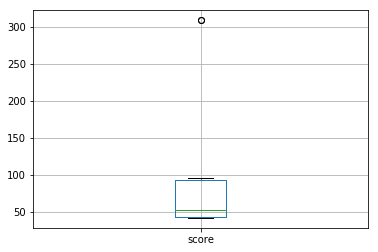

In [173]:
import matplotlib.pyplot as plt
df.boxplot(column=['score'])
plt.show()

Agora que temos o score de cada entidade nomeada, podemos eliminar os *outliers*. 

In [191]:
Q1 = df['score'].quantile(0.25)
Q3 = df['score'].quantile(0.75)
IQR = Q3 - Q1
df = df[ ( df.score > Q1 ) & ( df.score < Q3 + 1.5 * IQR ) ]
df

93.263749


,entity,score
2,Apache Spark,95.728527
3,Spark,95.728527
4,Apache Software Foundation,85.869415
5,Cloudera,85.342350
6,Apache Spark SQL,52.722824
7,Avro,52.722824
8,Apache Gora,44.040653
9,Apache Incubator,43.842365


Depois de termos eliminado os outliers, podemos normalizar os scores entre 0 e 1.

No grafo gerado por nosso servidor, os scores normalizados determinam a grossura das arestas entre os nós.  

Sendo assim, a grossura das arestas é proporcional à força da correlação entre as entidades nomeadas. 

In [193]:

normalized_score = [ ( ( x - Q1 ) / (Q3 + 1.5 * IQR - Q1) ) for x in df['score'].tolist() ]
normalized_score

[0.4196388507371126,
 0.4196388507371126,
 0.34108344778866223,
 0.33688390086648257,
 0.07697813968662626,
 0.07697813968662626,
 0.00780036369905751,
 0.006220445168885403]

# Iniciando o servidor  

Iremos utilizar as consultas e manipulações demonstradas acima para construir grafos de correlações entre entidades nomeadas.

A grossura das arestas é determinada pelos scores normalizados.

Na pasta principal do projeto, inicialize o servidor:

```
export FLASK_APP=server.py
flask run
```

Caso você esteja no Windows, será necessário executar, ao invés das duas linhas acima, o seguinte código:

```
set FLASK_APP=server.py
flask run
```


Após iniciar o servidor, basta acessar `http://localhost:5000/<n>/<termo>` para ver o grafo de entidades nomeadas relacionadas a `<termo>` com `<n>` níveis de profundidade.  

Por exemplo: a URL `http://localhost:5000/2/Hadoop` irá retornar o grafo de entidades nomeadas relacionadas a `Hadoop` em até dois níveis de profundidade.

Recomendamos fortemente que faça consultas em apenas um nível de profundidade, já que basta clicar em um nó no grafo para gerar uma nova consulta em uma nova aba que aprofunda o seu nível. Alguns exemplos de consultas:

`http://localhost:5000/1/Alan Turing`

`http://localhost:5000/1/Keanu Reeves`

`http://localhost:5000/1/Microsoft`

Enquanto espera pela página carregar, observe o terminal do servidor. Ele lhe informará qual nó relacionado à sua busca está sendo visitado por ele no momento.